In [1]:
# basics
import os, sys

# arrays
import numpy as np

# append sscode to path
sys.path.insert(0, '/home/metocean/geocean-nz-ss')
data_path = '/data' #'/data/storm_surge_data/'
os.environ["SSURGE_DATA_PATH"] = data_path

# custom
from sscode.config import default_location, \
    default_region, default_region_reduced
from sscode.data import Loader
from sscode.pca_new import PCA_DynamicPred

# warnings
import warnings
warnings.filterwarnings('ignore')

# for autocomplete code
%config Completer.use_jedi = False

import gc

DATA PATH /data
/data (173.9, -40.5) (140, 190, -70, -20) (160, 185, -52, -30)



 loading the sea-level-pressure fields... 


 resampling data to 6H... 


 loading and calculating the winds... 


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 -1.25 -1.408 ... -10.53
    vgrd10m         (time, latitude, longitude) float32 -8.33 -8.559 ... 10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 



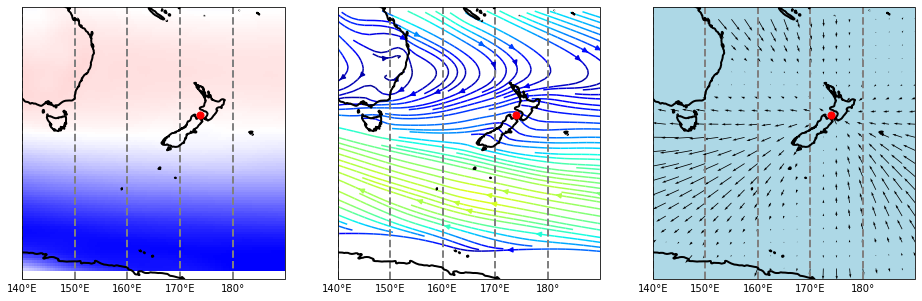


 loading the Moana v2 hindcast data... 


 loading and plotting the UHSLC tidal guages... 



In [2]:
# load the data
load_cfsr_moana_uhslc = Loader(
    data_to_load=['cfsr','moana','uhslc'], plot=False, 
    time_resample='6H', load_winds=True
)

In [3]:
class PCA_PreComputer(object):
    """
    This class Experiment summarizes all the previous work done with the linear and the
    knn models, as this class allows the user to perform a detailed analysis of one
    requested model given a set of parameters

    """

    def __init__(self, slp_data,
                 wind_data,
                 ss_data, # this must have several stations
                 sites_to_analyze,
                 # these are the metrics to evaluate the model
                 pca_attrs,
                 pcs_folder):
        """
        As the initializator, the __init__ function creates the instance of the class,
        given a set of parameters, which are described below

        Args:
            slp_data (xarray.Dataset): These are the sea-level-pressure fields, previously
                loaded with the Loader class, loader.predictor_slp!!
            wind_data (xarray.Dataset): These are the wind fields, previously
                loaded with the Loader class, loader.predictor_wind!!
            ss_data (xarray.Dataset): This is the storm surge from the moana hindcast, previously
                loaded with the Loader class, loader.predictand!!
            sites_to_analyze (list, optional): This is the list with all the moana v2
                hindcast locations to analyze. Defaults to random locations.
            pca_attrs (dict, optional): PCA dictionary with all the parameters to use in pca.
                Defaults to pca_attrs_default.
            pca_folder (string, optionl): The folder from/in which the PCs should be loaded/saved.
        """

        # lets build the experiment!! + with CFSR
        self.predictor_data = 'cfsr'

        # save class simplest attributes
        self.slp_data = slp_data
        self.wind_data = wind_data
        self.ss_data = ss_data
        self.ss_sites = sites_to_analyze
        self.pca_attrs = pca_attrs
        self.pcs_folder = pcs_folder
    

    def compute_pcas(self):
        """
        This function goes over all the sites/configurations and computes
        and stores the results of the PCA analysis if not already available.

        Args:
            

        Returns:
            
        """

        

        for isite,site in enumerate(self.ss_sites):

            # we first load in memmory the selected site
            ss_site = self.ss_data.isel(site=site)[[
                'ss','lat','lon'
            ]].load() # load the ss and the location of the site
            site_location = (ss_site.lon.values,ss_site.lat.values)

            # lets iterate over all the pca_attrs + model_attrs
            
                # loop over all the combinations for the linear model
            counter = 0
            for i_parameters,parameters in zip(
                [(icg,iw,itl,itr,ir) \
                    for icg in [i for i in range(len(list(self.pca_attrs.values())[0]))] \
                    for iw in [i for i in range(len(list(self.pca_attrs.values())[1]))] \
                    for itl in [i for i in range(len(list(self.pca_attrs.values())[2]))] \
                    for itr in [i for i in range(len(list(self.pca_attrs.values())[3]))] \
                    for ir in [i for i in range(len(list(self.pca_attrs.values())[4]))]]
                , [(cg,w,tl,tr,r) \
                    for cg in list(self.pca_attrs.values())[0] \
                    for w in list(self.pca_attrs.values())[1] \
                    for tl in list(self.pca_attrs.values())[2] \
                    for tr in list(self.pca_attrs.values())[3] \
                    for r in list(self.pca_attrs.values())[4]]
            ):  
                

                # Some info
                print(
                        '\n --------------------------------------------------------- \
                        \n\n Experiment {} in site {}, coords = {} ...... \
                        \n\n pca_params = {} \n\n \
                        \n\n and iteration with indexes = {} \
                        \n\n ---------------------------------------------------------'.format(
                            counter+1, # this is just the counter
                            site, # site to analyze in this loop
                            site_location, # site coordinates
                            dict(zip(self.pca_attrs.keys(),parameters[:5])),
                            i_parameters # this are the parameters indexes
                        ), end='\r'
                )

                # perform the experiment
                dict_to_pca = dict(zip(list(self.pca_attrs.keys()),parameters[:5]))
                trash = dict_to_pca.pop('winds')
                
                # change region parameter if local area is required
                if parameters[4][0]=='local':
                    local_region = (True,
                                    (site_location[0]-parameters[4][1][0], # new lon / lat region
                                     site_location[0]+parameters[4][1][0],
                                     site_location[1]-parameters[4][1][1],
                                     site_location[1]+parameters[4][1][1]
                                    ))
                    dict_to_pca['region'] = local_region

                pca_data, pca_scaler = PCA_DynamicPred(
                        self.slp_data,
                        pres_vars=('SLP','longitude','latitude'),
                        wind=self.wind_data if parameters[1] else None,
                        wind_vars=('wind_proj_mask','longitude','latitude','ugrd10m','vgrd10m'),
                        pca_plot=(False,False,1),
                        verbose=False,
                        pcs_folder=self.pcs_folder,
                        site_id=site,
                        site_location=site_location,
                        pca_percent=0.99,
                        pca_method='cpu',
                        **dict_to_pca # extra arguments without the winds
                    ).pcs_get()
                    
                
                # This seems necessary to keep memory under control    
                del pca_data
                del pca_scaler
                gc.collect()

In [ ]:
pca_attrs = {
    'calculate_gradient': [True],
    'winds': [True],
    'time_lapse': [1], #2,3], # 1 equals to NO time delay 
    'time_resample': ['12H'], # 1D and 12H, 6H available...
    #'region': [('local',(1.5,1.5))]#,('local',(2.5,2.5)),(True,default_region_reduced)]
    'region': [('local',(1.5,1.5))]# ,(True,default_region_reduced)]
    #'region': [(True,default_region_reduced)]
}

sites_to_analyze = np.unique( # closest Moana v2 Hindcast to tidal gauges
    [  689,328,393,1327,393,480,999,116,224,1124,949,708, # UHSLC
      1296,378,1124,780,613,488,1442,1217,578,200,1177,1025,689,949,224,1146, # LINZ
      1174,1260,1217,744,1064,1214,803,999 # OTHER (ports...)
    ]
    #[ 613,488,1442,1217,578,200,1177,1025,689,949,224,1146 ]
    #[1174,1260,1217]
)

sites_to_analyze = range(1448) # 1448 points in total


PCA_precomputer = PCA_PreComputer(
           load_cfsr_moana_uhslc.predictor_slp,
            load_cfsr_moana_uhslc.predictor_wind,
            # load_cfsr_moana_uhslc.predictor_wind,
            load_cfsr_moana_uhslc.predictand, # all the sites are passed to exp at first
            sites_to_analyze=sites_to_analyze, 
            pca_attrs=pca_attrs,
            pcs_folder = '/home/metocean/pcas'
        )

PCA_precomputer.compute_pcas()


 ---------------------------------------------------------                         

 Experiment 1 in site 0, coords = (array(165.98740554), array(-50.95653983)) ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 1, 'time_resample': '12H', 'region': ('local', (1.5, 1.5))} 

                         

 and iteration with indexes = (0, 0, 0, 0, 0)                         

time resample 12H-----------------------------------------
/home/metocean/pcas ['local_1.5_1.5', '0', 'winds', 'gradients', '12H', 'tl1']
FILE /home/metocean/pcas/local_1.5_1.5_0_winds_gradients_12H_tl1.nc

 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         27G         18M         10G         36G
Swap:          3.9G        212M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         27G         18M         10G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         27G         18M         10G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         27G         18M         10G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         27G         18M         10G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         27G         18M         10G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         27G         18M         10G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         27G         18M         10G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         27G         18M         10G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         27G         18M         10G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         27G         18M         10G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         27G         18M         10G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         27G         18M         10G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         27G         18M         10G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         27G         18M         10G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         27G         18M         10G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         27G         18M         10G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         27G         18M         10G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         27G         18M         10G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         27G         18M         10G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         27G         18M         10G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         27G         18M         10G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         27G         18M         10G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         27G         18M         10G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         27G         18M         10G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         27G         18M         10G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         27G         18M         10G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         27G         18M         10G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         27G         18M         10G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         27G         18M         10G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         27G         18M         10G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         27G         18M         10G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         27G         18M         10G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         27G         18M         10G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         27G         18M         10G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         27G         18M         10G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         27G         18M         10G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         27G         18M         10G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         27G         18M         10G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         27G         18M         10G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         27G         18M         10G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         27G         18M         10G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         27G         18M         10G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         27G         18M         10G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         27G         18M         10G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         27G         18M         10G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         27G         18M         10G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         27G         18M         10G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         27G         18M         10G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         27G         18M         10G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         27G         18M         10G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         27G         18M         10G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         27G         18M         10G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         27G         18M         10G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         27G         18M         10G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         27G         18M         10G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         27G         18M         10G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 ---------------------------------------------------------                         

 Experiment 1 in site 117, coords = (array(168.40554156), array(-46.62520765)) ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 1, 'time_resample': '12H', 'region': ('local', (1.5, 1.5))} 

                         

 and iteration with indexes = (0, 0, 0, 0, 0)                         

time resample 12H-----------------------------------------
/home/metocean/pcas ['local_1.5_1.5', '117', 'winds', 'gradients', '12H', 'tl1']
FILE /home/metocean/pcas/local_1.5_1.5_117_winds_gradients_12H_tl1.nc

 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data vari


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         27G         18M         10G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         27G         18M         10G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         27G         18M         10G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         27G         18M         10G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         27G         18M         10G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         27G         18M         10G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         27G         18M         10G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         27G         18M         10G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         27G         18M         10G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         27G         18M         10G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         27G         18M         10G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         27G         18M         10G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         27G         18M         10G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         27G         18M         10G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         27G         18M         10G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         27G         18M         10G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         27G         18M         10G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         27G         18M         10G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         27G         18M         10G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         27G         18M         10G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         27G         18M         10G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         27G         18M         10G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         27G         18M         10G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         27G         18M         10G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         27G         18M         10G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         27G         18M         10G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         27G         18M         10G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         27G         18M         10G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         27G         18M         10G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         27G         18M         10G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         27G         18M         10G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         27G         18M         10G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         27G         18M         10G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         27G         18M         10G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         27G         18M         10G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         27G         18M         10G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         27G         18M         10G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         27G         18M         10G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         27G         18M         10G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         27G         18M         10G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         27G         18M         10G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         27G         18M         10G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         27G         18M         10G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         27G         18M         10G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         27G         18M         10G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         27G         18M         10G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         27G         18M         10G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         27G         18M         10G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         27G         18M         10G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         27G         18M         10G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         27G         18M         10G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         27G         18M         10G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 ---------------------------------------------------------                         

 Experiment 1 in site 225, coords = (array(166.41057935), array(-45.78187862)) ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 1, 'time_resample': '12H', 'region': ('local', (1.5, 1.5))} 

                         

 and iteration with indexes = (0, 0, 0, 0, 0)                         

time resample 12H-----------------------------------------
/home/metocean/pcas ['local_1.5_1.5', '225', 'winds', 'gradients', '12H', 'tl1']
FILE /home/metocean/pcas/local_1.5_1.5_225_winds_gradients_12H_tl1.nc

 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data vari


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         27G         18M         10G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         27G         18M         10G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         27G         18M         10G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         27G         18M         10G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         27G         18M         10G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         27G         18M         10G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         27G         18M         10G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         27G         18M         10G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         27G         18M         10G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         27G         18M         10G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         27G         18M         10G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         27G         18M         10G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         27G         18M         10G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         27G         18M         10G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         27G         18M         10G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         27G         18M         10G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         27G         18M         10G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         26G         18M         10G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         26G         18M         10G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         26G         18M         10G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         26G         18M         10G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         26G         18M         10G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         26G         18M         10G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         26G         18M         10G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         26G         18M         10G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         26G         18M         10G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         26G         18M         10G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         26G         18M         10G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         26G         18M         10G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         26G         18M         10G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         26G         18M         10G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         26G         18M         10G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         26G         18M         10G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         26G         18M         10G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         26G         18M         10G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         26G         18M         10G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         26G         18M         10G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         26G         18M         10G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         26G         18M         10G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         26G         18M         10G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         26G         18M         10G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         26G         18M         11G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         26G         18M         11G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         26G         18M         11G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         26G         18M         11G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         26G         18M         11G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         26G         18M         11G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         26G         18M         11G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         26G         18M         11G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         26G         18M         11G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         26G         18M         11G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         26G         18M         11G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         26G         18M         11G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         26G         18M         11G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         26G         18M         11G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         26G         18M         11G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         26G         18M         11G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         26G         18M         11G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         26G         18M         11G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         26G         18M         11G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         26G         18M         11G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         26G         18M         11G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         26G         18M         11G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         26G         18M         11G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         26G         18M         11G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         26G         18M         11G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         26G         18M         11G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         26G         18M         11G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         26G         18M         11G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         26G         18M         11G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         26G         18M         11G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         26G         18M         11G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         26G         18M         11G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         26G         18M         11G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         26G         18M         11G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 ---------------------------------------------------------                         

 Experiment 1 in site 379, coords = (array(183.70025189), array(-44.01255784)) ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 1, 'time_resample': '12H', 'region': ('local', (1.5, 1.5))} 

                         

 and iteration with indexes = (0, 0, 0, 0, 0)                         

time resample 12H-----------------------------------------
/home/metocean/pcas ['local_1.5_1.5', '379', 'winds', 'gradients', '12H', 'tl1']
FILE /home/metocean/pcas/local_1.5_1.5_379_winds_gradients_12H_tl1.nc

 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data vari


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         26G         18M         11G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         26G         18M         11G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         26G         18M         11G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         26G         18M         11G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         26G         18M         11G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         26G         18M         11G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 ---------------------------------------------------------                         

 Experiment 1 in site 394, coords = (array(168.64735516), array(-43.92485685)) ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 1, 'time_resample': '12H', 'region': ('local', (1.5, 1.5))} 

                         

 and iteration with indexes = (0, 0, 0, 0, 0)                         

time resample 12H-----------------------------------------
/home/metocean/pcas ['local_1.5_1.5', '394', 'winds', 'gradients', '12H', 'tl1']
FILE /home/metocean/pcas/local_1.5_1.5_394_winds_gradients_12H_tl1.nc

 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data vari


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         26G         18M         11G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         26G         18M         11G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         26G         18M         11G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         26G         18M         11G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         26G         18M         11G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         26G         18M         11G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         26G         18M         11G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         26G         18M         11G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         26G         18M         11G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         26G         18M         11G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         26G         18M         11G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         26G         18M         11G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         26G         18M         11G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         26G         18M         11G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         26G         18M         11G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         26G         18M         11G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         26G         18M         11G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         26G         18M         11G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         26G         18M         11G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         26G         18M         11G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         26G         18M         11G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         26G         18M         11G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (time: 46141, latitude: 160, longitude: 161)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 ... 2021-08-01
  * latitude        (latitude) float32 -69.78 -69.47 -69.16 ... -20.45 -20.14
  * longitude       (longitude) float32 140.0 140.3 140.6 ... 189.4 189.7 190.0
Data variables:
    ugrd10m         (time, latitude, longitude) float32 1.25 1.408 ... 10.53
    vgrd10m         (time, latitude, longitude) float32 8.33 8.559 ... -10.06
    uw2             (time, latitude, longitude) float32 1.562 1.982 ... 110.8
    vw2             (time, latitude, longitude) float32 69.39 73.25 ... 101.2
    wind_magnitude  (time, latitude, longitude) float32 8.423 8.674 ... 14.56 

Assembling matrix
              total        used        free      shared  buff/cache   available
Mem:           125G         87G         26G         18M         11G         36G
Swap:          3.9G        215M        3.7G
Start 0
<xarray.Datas

In [ ]:
print("Done")